# New approach to GPs to improve performance

In [1]:
from scipy import stats, special, math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pymc3 as pm
import arviz as az
import pandas as pd
from theano import shared
import seaborn as sns
import warnings
import theano
import theano.tensor as tt
import calendar

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [155]:
data = pd.read_csv('./data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)

y_train = data.iloc[:-8,:30]
y_ = y_train.values.flatten('F')
y = data.iloc[:,:30]
y_f = y.values

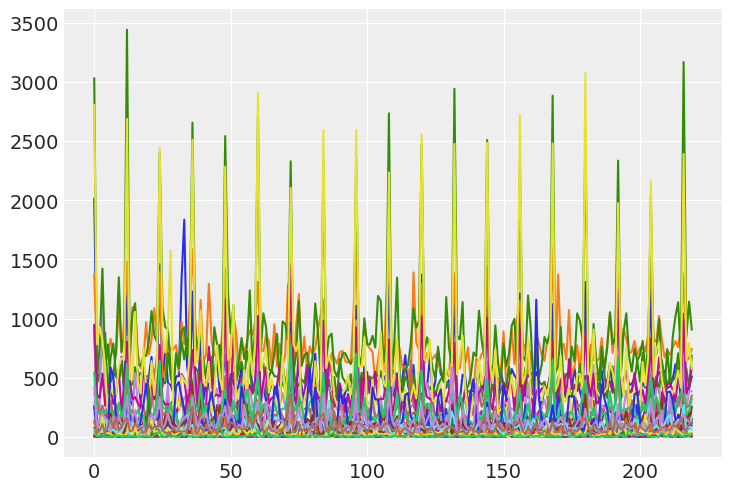

In [156]:
def generate_groups_info(y):
    
    n=y.shape[0]
    s=y.shape[1]
    n_series = y.columns.unique().shape[0]
    
    state_idx = pd.get_dummies(
            [i[0] for i in y]
        ).values.argmax(1)
    state_idx = np.tile(state_idx, (n,1)).flatten('F')
    zone_idx = pd.get_dummies(
            [i[1] for i in y]
        ).values.argmax(1)
    zone_idx = np.tile(zone_idx, (n,1)).flatten('F')
    region_idx = pd.get_dummies(
            [i[2] for i in y]
        ).values.argmax(1)
    region_idx = np.tile(region_idx, (n,1)).flatten('F')
    purpose_idx = pd.get_dummies(
            [i[3:6] for i in y]
        ).values.argmax(1)
    purpose_idx = np.tile(purpose_idx, (n,1)).flatten('F')

    n_series_idx = np.tile(np.arange(s), (n,1)).flatten('F')
    n_series_idx_list = np.arange(s)
    
    state = np.unique(state_idx).shape[0]
    zone = np.unique(zone_idx).shape[0]
    region = np.unique(region_idx).shape[0]
    purpose = np.unique(purpose_idx).shape[0]
    
    state_names = []
    zone_names = []
    region_names = []
    purpose_names = []
    [state_names.append('s' + i[0]) for i in y.columns]
    [zone_names.append('z' + i[1]) for i in y.columns]
    [region_names.append('r' + i[2]) for i in y.columns]
    [purpose_names.append(i[3:6]) for i in y.columns]

    state_names = np.unique(state_names)
    zone_names = np.unique(zone_names)
    region_names = np.unique(region_names)
    purpose_names = np.unique(purpose_names)

    return (state_idx, 
            zone_idx,
            region_idx,
            purpose_idx,
            n_series_idx,
            state,
            zone,
            region,
            purpose,
            n,
            s,
            n_series,
            state_names,
            zone_names,
            region_names,
            purpose_names
           )


state_names=[]
zone_names=[]
region_names=[]
purpose_names=[]

(state_idx, 
 zone_idx, 
 region_idx,
 purpose_idx,
 n_series_idx, 
 state, 
 zone,
 region,
 purpose,
 n,
 s,
 n_series,
 state_names,
 zone_names,
 region_names,
 purpose_names) = generate_groups_info(y_train)


y_train = y_train.values
y_ = y_train
X = np.arange(y_train.shape[0]).reshape(y_train.shape[0], 1)
plt.plot(X, y_train);

y_ = y_.T.ravel()

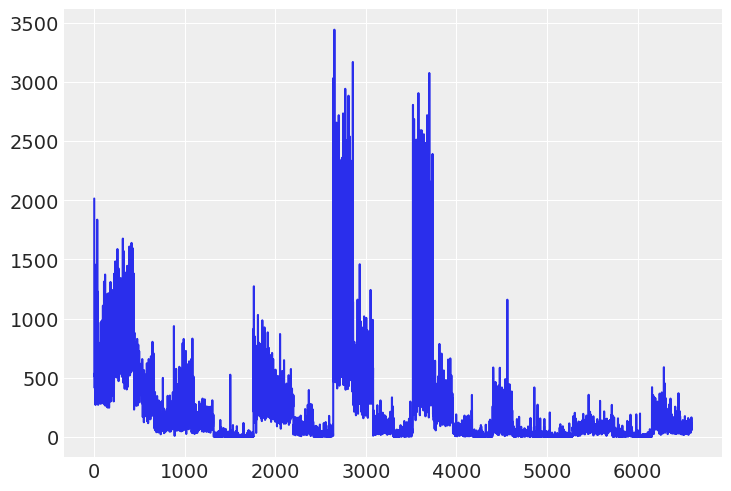

In [157]:
plt.plot(y_);

We will define a more compact covariance matrices to model latent behaviours of each element of each group. We only need them to be UxU where U is the unique number of inputs for the given GP. All the GPs will therefore have a covariance matrix that depend on number of time points and it would be txt, where t is the number of periods observed in the data. In our case it is 48. The Poisson likelihood needs to be computed for the N data points (all time series).

In [158]:
changepoints = 4
changepoints_t = np.linspace(0, n, changepoints + 2)[1:-1]
changepoints_t

array([ 44.,  88., 132., 176.])

In [159]:
def dm_changepoints_theano(X, changepoints_t):
    return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints_t))) - changepoints_t)))

class PiecewiseLinearChangepoints(pm.gp.mean.Mean):
    def __init__(self, 
                 k, 
                 m,
                 b,
                 intercept, 
                 changepoints):
        self.k = k
        self.m = m
        self.b = b
        self.a = intercept
        self.changepoints = changepoints

    def __call__(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = dm_changepoints_theano(X[:n,0], self.changepoints)
        
        piecewise = (self.k + tt.dot(A, self.b.reshape((-1,1))))*X + (self.m + tt.dot(A, (-self.changepoints * self.b).reshape((-1,1))))
        
        return (piecewise.reshape((-1,))
                       + tt.tile(self.a, (size_r,)))

In [160]:
gp_dict = {}
f_dict = {}
f_flat = {}
idx_dict = {}

with pm.Model() as model:
    
    # Hyper-parameter priors
    
    # Select the seasonality for the data, in this case it is monthly
    period = pm.Laplace('period', 12, 0.1)
  
    
    l_t_state = pm.Gamma('l_t_state', alpha=5, beta=1, shape = state)
    l_p_state = pm.Gamma('l_p_state', alpha=2, beta=1, shape = state)
    η_trend_state = pm.HalfNormal('η_trend_state', 0.15, shape = state)
    η_per_state = pm.HalfNormal('η_per_state',0.5, shape = state)
    σ_state  = pm.HalfNormal("σ_state",  sigma=0.01, shape = state)
    
    l_t_zone = pm.Gamma('l_t_zone', alpha=5, beta=1, shape = zone)
    l_p_zone = pm.Gamma('l_p_zone', alpha=2, beta=1, shape = zone)
    η_trend_zone = pm.HalfNormal('η_trend_zone', 0.15, shape = zone)
    η_per_zone = pm.HalfNormal('η_per_zone',0.5, shape = zone)
    σ_zone  = pm.HalfNormal("σ_zone",  sigma=0.01, shape = zone)
    
    l_t_region = pm.Gamma('l_t_region', alpha=5, beta=1, shape = region)
    l_p_region = pm.Gamma('l_p_region', alpha=2, beta=1, shape = region)
    η_trend_region = pm.HalfNormal('η_trend_region', 0.15, shape = region)
    η_per_region = pm.HalfNormal('η_per_region',0.5, shape = region)
    σ_region  = pm.HalfNormal("σ_region",  sigma=0.01, shape = region)
    
    l_t_purpose = pm.Gamma('l_t_purpose', alpha=5, beta=1, shape = purpose)
    l_p_purpose = pm.Gamma('l_p_purpose', alpha=2, beta=1, shape = purpose)
    η_trend_purpose = pm.HalfNormal('η_trend_purpose', 0.15, shape = purpose)
    η_per_purpose = pm.HalfNormal('η_per_purpose',0.5, shape = purpose)
    σ_purpose  = pm.HalfNormal("σ_purpose",  sigma=0.01, shape = purpose)
    
    
    hy_a0_mu = pm.Normal('hy_a0_mu', mu=0.0, sd=10)
    hy_a_state = pm.Normal('hy_a_state', mu=0.0, sd=5)
    hy_a_zone = pm.Normal('hy_a_zone', mu=0.0, sd=5)
    hy_a_region = pm.Normal('hy_a_region', mu=0.0, sd=5)
    hy_a_purpose = pm.Normal('hy_a_purpose', mu=0.0, sd=5)
    
    hy_b_state = pm.Normal('hy_b_state', mu=0.0, sd=0.5)
    hy_b_zone = pm.Normal('hy_b_zone', mu=0.0, sd=0.5)
    hy_b_region = pm.Normal('hy_b_region', mu=0.0, sd=0.5)
    hy_b_purpose = pm.Normal('hy_b_purpose', mu=0.0, sd=0.5)
    
    a0 = pm.Normal('a0', mu=hy_a0_mu, sd=5, shape=n_series)      
    a_state = pm.Normal('a_state', mu=hy_a_state, sd=1, shape=state)
    a_zone = pm.Normal('a_zone', mu=hy_a_zone, sd=1, shape=zone)
    a_region = pm.Normal('a_region', mu=hy_a_region, sd=1, shape=region)
    a_purpose = pm.Normal('a_purpose', mu=hy_a_purpose, sd=1, shape=purpose)

    b_state = pm.Normal('b_state', mu=hy_b_state, sd=0.1, shape=(len(changepoints_t),state))
    b_zone = pm.Normal('b_zone', mu=hy_b_zone, sd=0.1, shape=(len(changepoints_t),zone))
    b_region = pm.Normal('b_region', mu=hy_b_region, sd=0.1, shape=(len(changepoints_t),region))
    b_purpose = pm.Normal('b_purpose', mu=hy_b_purpose, sd=0.1, shape=(len(changepoints_t),purpose))

    
    k_state = pm.Normal("k_state", mu=0, sigma=0.1, shape=state)
    m_state = pm.Normal("m_state", mu=0, sigma=0.1, shape=state)
    k_zone = pm.Normal("k_zone", mu=0, sigma=0.1, shape=zone)
    m_zone = pm.Normal("m_zone", mu=0, sigma=0.1, shape=zone)
    k_region = pm.Normal("k_region", mu=0, sigma=0.1, shape=region)
    m_region = pm.Normal("m_region", mu=0, sigma=0.1, shape=region)
    k_purpose = pm.Normal("k_purpose", mu=0, sigma=0.1, shape=purpose)
    m_purpose = pm.Normal("m_purpose", mu=0, sigma=0.1, shape=purpose)
       
    for idx, name in enumerate(state_names):
        
        # index varible that indicates where a specific GP is active
        # for instance, GP_fem is only active in fem time series
        idx_dict[name] = np.where(state_idx==idx,1,0)
        
        # mean function for the GP with specific parameters per group
        mu_func = PiecewiseLinearChangepoints(intercept = a_state[idx],
                                              b = b_state[:,idx],
                                              changepoints = changepoints_t,
                                              k = k_state[idx],
                                              m = m_state[idx])
        
        # cov function for the GP with specific parameters per group
        cov = (η_trend_state[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_state[idx])
                + η_per_state[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_state[idx]) 
                + pm.gp.cov.WhiteNoise(σ_state[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    for idx, name in enumerate(zone_names):
        
        idx_dict[name] = np.where(zone_idx==idx,1,0)
        
        mu_func = PiecewiseLinearChangepoints(intercept = a_zone[idx],
                                              b = b_zone[:,idx],
                                              changepoints = changepoints_t,
                                              k = k_zone[idx],
                                              m = m_zone[idx])
        
        cov = (η_trend_zone[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_zone[idx])
                + η_per_zone[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_zone[idx]) 
                + pm.gp.cov.WhiteNoise(σ_zone[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    for idx, name in enumerate(region_names):
        
        idx_dict[name] = np.where(region_idx==idx,1,0)
        
        mu_func = PiecewiseLinearChangepoints(intercept = a_region[idx],
                                              b = b_region[:,idx],
                                              changepoints = changepoints_t,
                                              k = k_region[idx],
                                              m = m_region[idx])
        
        cov = (η_trend_region[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_region[idx])
                + η_per_region[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_region[idx]) 
                + pm.gp.cov.WhiteNoise(σ_region[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]

    for idx, name in enumerate(purpose_names):
        
        idx_dict[name] = np.where(purpose_idx==idx,1,0)
        
        mu_func = PiecewiseLinearChangepoints(intercept = a_purpose[idx],
                                              b = b_purpose[:,idx],
                                              changepoints = changepoints_t,
                                              k = k_purpose[idx],
                                              m = m_purpose[idx])
        
        cov = (η_trend_purpose[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_purpose[idx])
                + η_per_purpose[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_purpose[idx]) 
                + pm.gp.cov.WhiteNoise(σ_purpose[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
    
    # Sum of all the GPs designed per group
    f = sum(f_flat.values())
        
    
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f + a0[n_series_idx]), observed=y_)

In [161]:
with model:
    mp = pm.find_MAP()

In [162]:
mp_list = [{key: mp.get(key) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'rotated'])]}]

In [163]:
mp_list

[{'period': array(12.00011604),
  'hy_a0_mu': array(2.6447801e-05),
  'hy_a_state': array(0.0006611),
  'hy_a_zone': array(0.00066073),
  'hy_a_region': array(0.00066086),
  'hy_a_purpose': array(0.00066073),
  'hy_b_state': array(4.93056375e-05),
  'hy_b_zone': array(5.91736015e-05),
  'hy_b_region': array(5.68295437e-05),
  'hy_b_purpose': array(5.91736015e-05),
  'a0': array([ 0.10025314,  1.00207853,  1.56339611,  1.26204413, -0.51068146,
         -0.32524571, -1.45232234, -1.10855272, -0.5843222 , -0.28691202,
         -0.3545132 , -0.55053065,  1.00680211,  0.78497317,  0.23388827,
          0.26194878,  0.71178241,  0.09820749, -0.16536217, -0.35094326,
          0.11492657, -1.30515116, -0.41948847, -0.33213069, -0.07006198,
          0.41983622,  0.68226884,  0.32314008,  0.20010776,  0.2217511 ]),
  'a_state': array([1.17055201]),
  'a_zone': array([ 0.53068569,  0.51107805,  0.29354125, -0.16475262]),
  'a_region': array([0.503016  , 0.24582824, 0.42170802]),
  'a_purpose': 

In [164]:
with model:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred], 
                                                  samples=500)

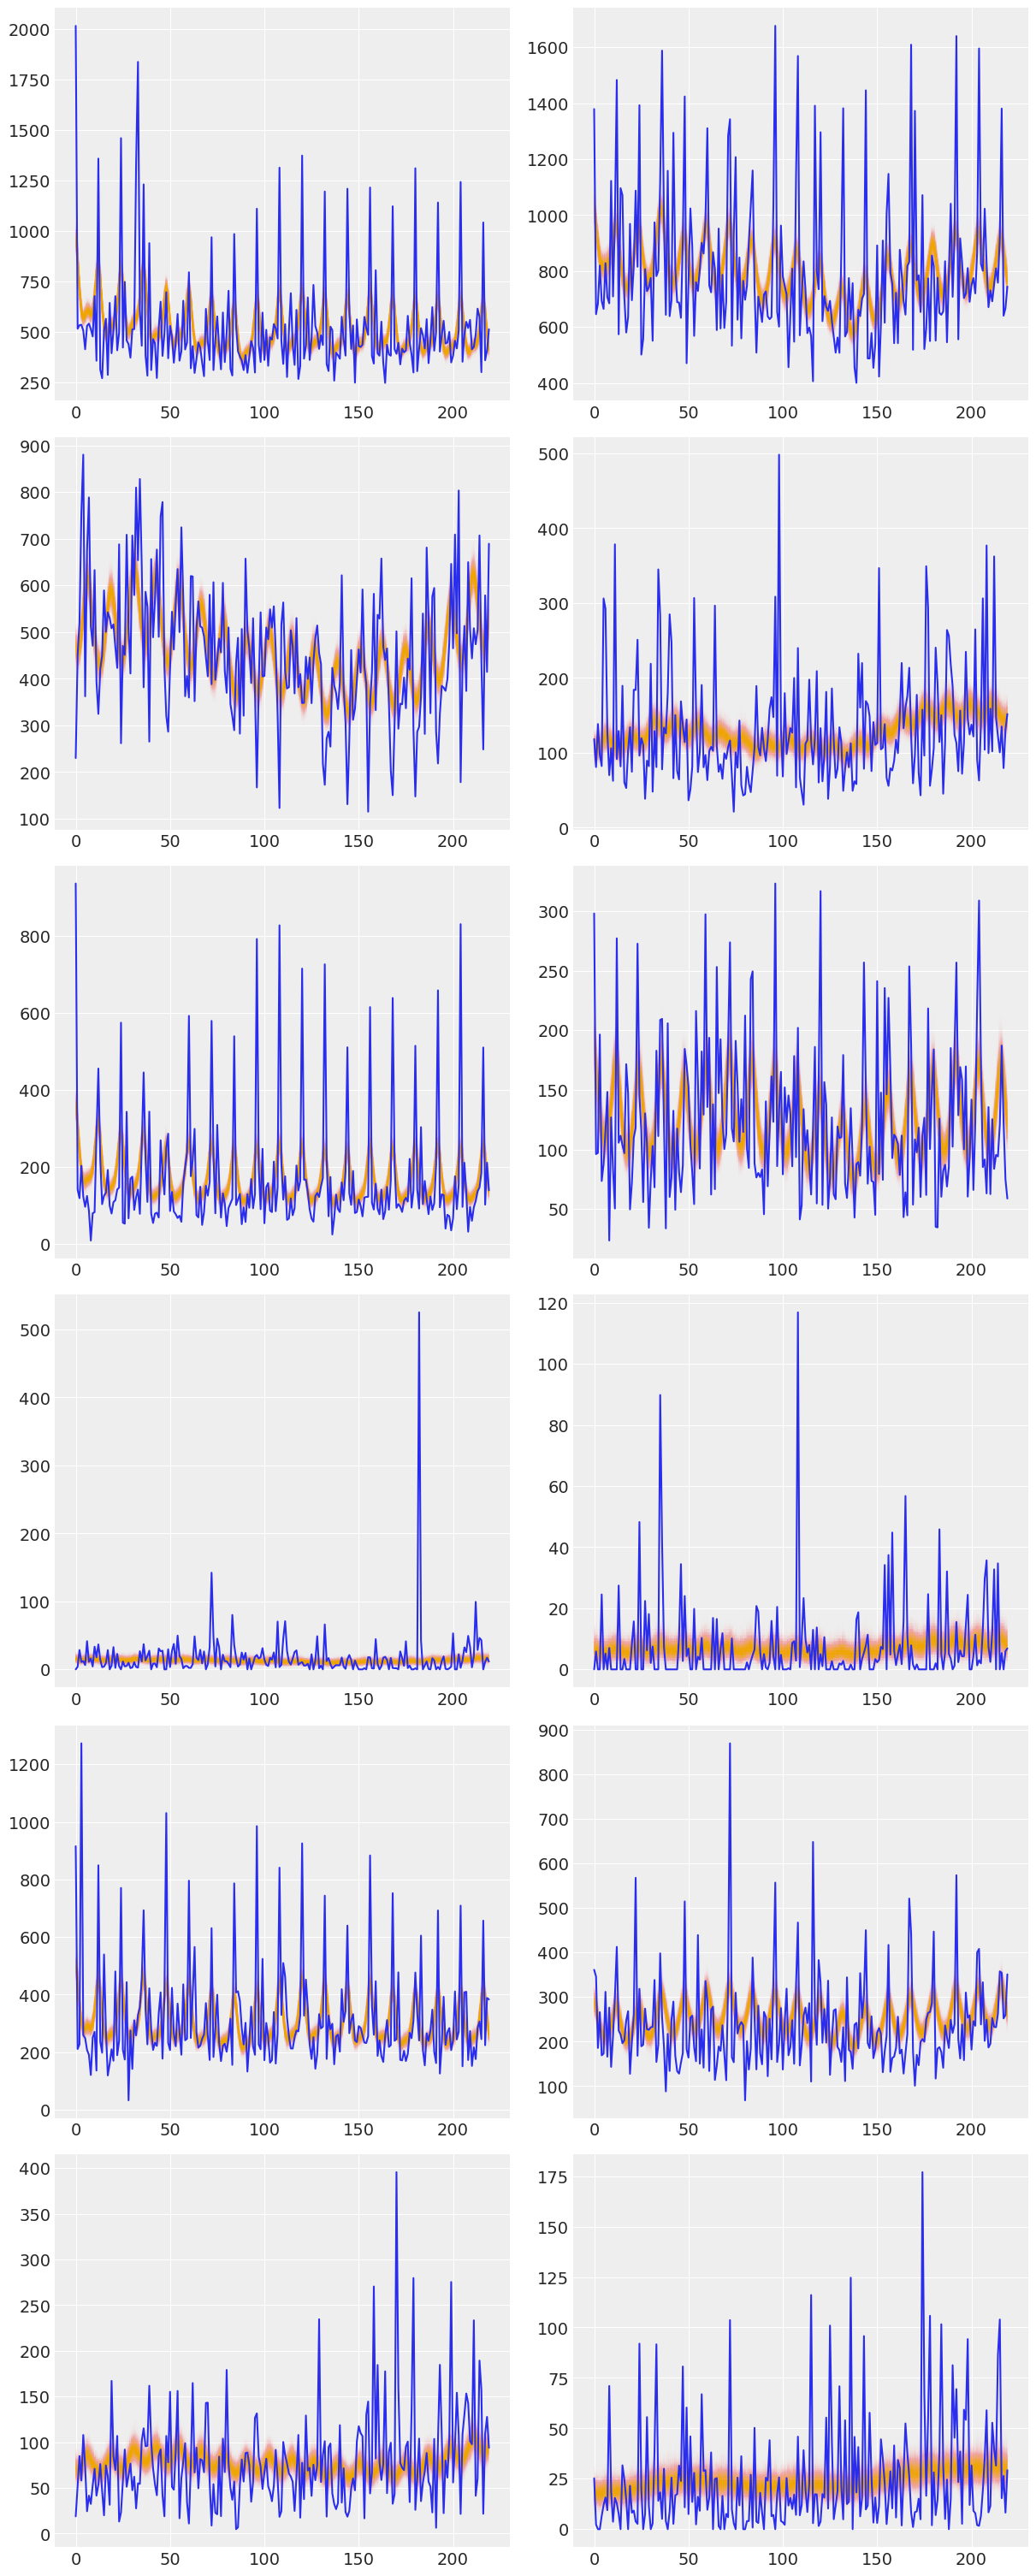

In [165]:
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)
for i in range(12):
    ax[i].plot(np.arange(n), pred_samples['y_pred'].T[i*n:i*n+n,:], alpha=0.003, color='orange')
    ax[i].plot(y_train[:,i]);

In [166]:
h = 8
n_new = n+h
X_new = np.arange(n_new).reshape(-1,1)

In [167]:
(state_idx, 
 zone_idx, 
 region_idx,
 purpose_idx,
 n_series_idx, 
 state, 
 zone,
 region,
 purpose,
 n,
 s,
 n_series,
 state_names,
 zone_names,
 region_names,
 purpose_names) = generate_groups_info(y)

In [168]:
f_new = {}
f_flat_new = {}
idx_dict_new = {}

with model:
    
    for idx, name in enumerate(state_names):
        idx_dict_new[name] = np.where(state_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]

    for idx, name in enumerate(zone_names):
        idx_dict_new[name] = np.where(zone_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]
        
    for idx, name in enumerate(region_names):
        idx_dict_new[name] = np.where(region_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]
        
    for idx, name in enumerate(purpose_names):
        idx_dict_new[name] = np.where(purpose_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]

In [169]:
with model:

    f_ = sum(f_flat_new.values())
    
    y_pred_new = pm.Poisson("y_pred_new", 
                            mu=pm.math.exp(f_ + a0[n_series_idx]), 
                            shape=n_new * s)

In [170]:
with model:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new], 
                                                  samples=200)

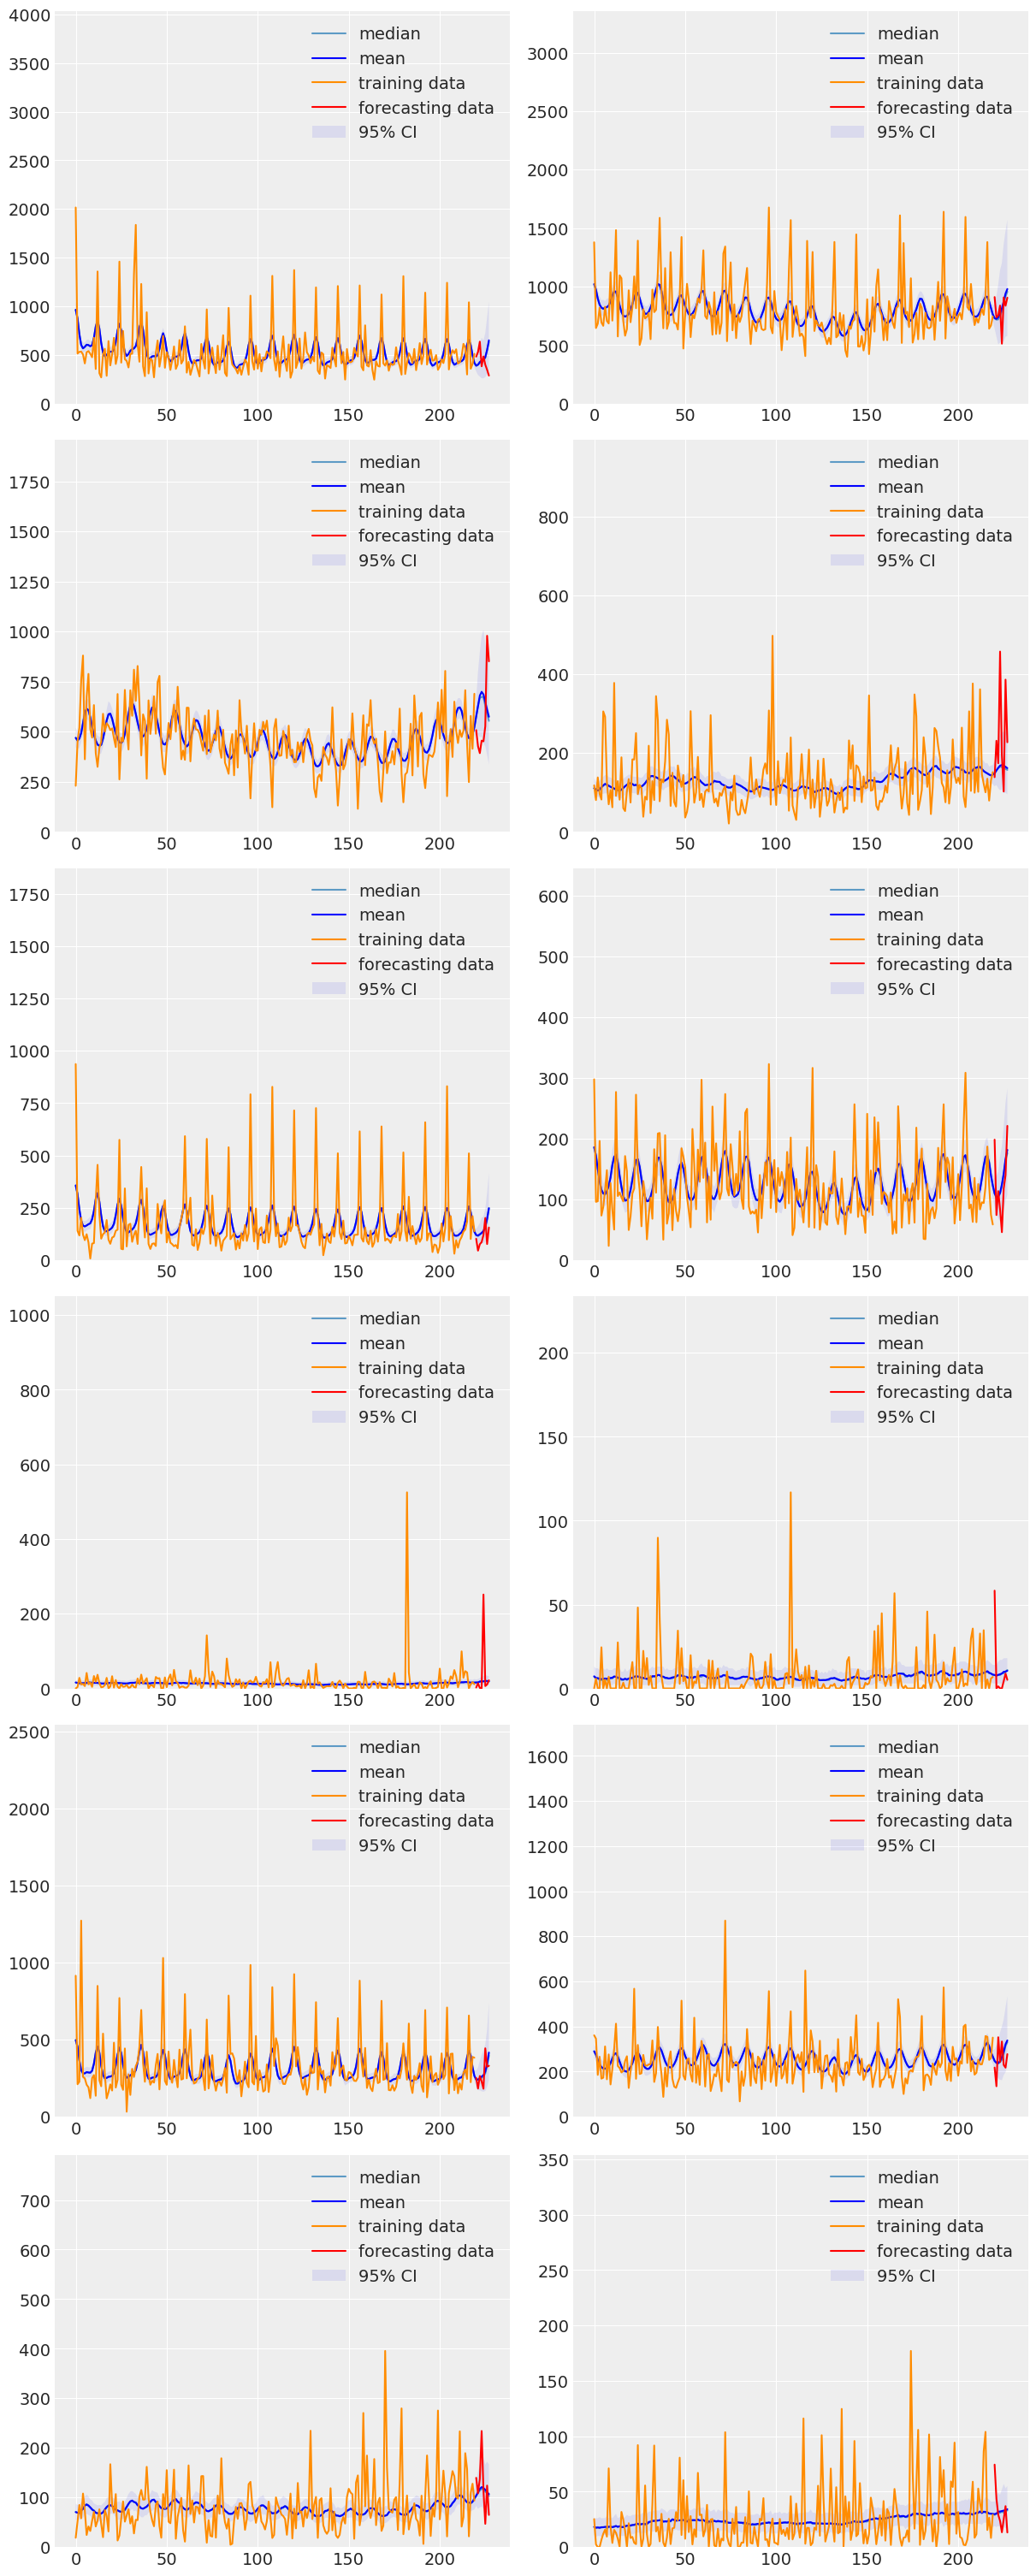

In [171]:
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)

for i in range(12):
    #ax[i].plot(np.arange(n_new), pred_samples['y_pred_new'].T[i*n:i*n+n,:], alpha=0.003, color='blue')
    ax[i].fill_between(np.arange(n_new), 
                       np.percentile(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1, q=2.5),
                      np.percentile(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1, q=97.5),
                      label='95% CI', alpha=0.1)
    ax[i].plot(np.arange(n_new), np.median(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1), color='tab:blue', alpha=0.7, label='median')
    ax[i].plot(np.arange(n_new), np.mean(pred_samples['y_pred_new'].T[i*n:i*n+n,:], axis=1), color='b', label='mean')
    ax[i].set_ylim(0,max(y_f[:,i])*2)
    ax[i].plot(y_f[:-8,i], color='darkorange', label='training data')
    ax[i].plot(np.arange(n_new -8, n_new), y_f[n_new-8:,i], color='r', label='forecasting data')
    ax[i].legend();

# Results

https://arxiv.org/pdf/2006.02043.pdf

$$MASE = \frac{n-s}{h}\frac{\sum^{n+h}_{t=n+1}|y_t-f_t|}{\sum^n_{t=s+1}|y_t-y_{t-s}|}$$

where $y_t$ and $f_t$ are the observation and the forecast for period $t$,$n$ is the sample size (observations used for training the forecasting model), $s$ is the length of the seasonal period, and $h$ is the forecasting horizon. Lower values indicate better forecasts.

Note that measure is scale-independent, meaning that averaging across series is possible.

In [172]:
def mase(n,s,h,y,f, series=0):
    return ((n-s)/h
            * (np.sum(np.abs(y[n:n+h,series] - f[:,series]))
               / np.sum(np.abs(y[s:n, series] - y[:n-s, series]))))

### Using Mean

In [173]:
mase_sum_bottom = []
for i in range(s):
    mase_sum_bottom.append(mase(n=40, 
                         s=4, 
                         h=8, 
                         y=y_f, 
                         f=np.mean(pred_samples['y_pred_new'], axis=0).reshape(s, n).T[n-8:n,:], 
                         series=i))
    
mase_bottom = np.sum(mase_sum_bottom)/s
mase_bottom

0.8315378131193155

In [174]:
mase_total = mase(n=40, 
                 s=4, 
                 h=8, 
                 y=np.sum(y_f, axis=1).reshape(-1,1), 
                 f=np.sum(np.mean(pred_samples['y_pred_new'], axis=0).reshape(s, n).T[n-8:n,:], axis=1).reshape(-1,1))
    
mase_total

0.48128655410007926

In [175]:
idx_state_new = {key: idx_dict_new.get(key) for key in 
  [i for i in idx_dict_new if 
   any(j in i for j in state_names)]}

In [176]:
y_st = np.zeros((n, state_names.shape[0]))
f_st = np.zeros((8, state_names.shape[0]))

for i, st in enumerate(state_names):
    y_st[:,i] = np.sum(idx_state_new[st].reshape(s, n).T*y_f, axis=1)
    f_st[:,i] = np.sum(idx_state_new[st].reshape(s, n).T*np.mean(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

In [177]:
mase_state = []
for i in range(state):
    mase_state.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_st, 
                     f=f_st,
                     series=i))

mase_state = np.sum(mase_state)/state
mase_state

0.48128655410007926

In [178]:
idx_zone_new = {key: idx_dict_new.get(key) for key in 
  [i for i in idx_dict_new if 
   any(j in i for j in zone_names)]}

In [179]:
y_zo = np.zeros((n, zone_names.shape[0]))
f_zo = np.zeros((8, zone_names.shape[0]))

for i, zo in enumerate(zone_names):
    y_zo[:,i] = np.sum(idx_zone_new[zo].reshape(s, n).T*y_f, axis=1)
    f_zo[:,i] = np.sum(idx_zone_new[zo].reshape(s, n).T*np.mean(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

In [180]:
mase_zone = []
for i in range(zone):
    mase_zone.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_zo, 
                     f=f_zo,
                     series=i))

mase_zone = np.sum(mase_zone)/zone
mase_zone

0.4618754382544785

In [181]:
idx_region_new = {key: idx_dict_new.get(key) for key in 
  [i for i in idx_dict_new if 
   any(j in i for j in region_names)]}

In [184]:
y_re = np.zeros((n, region_names.shape[0]))
f_re = np.zeros((8, region_names.shape[0]))

for i, re in enumerate(region_names):
    y_re[:,i] = np.sum(idx_region_new[re].reshape(s, n).T*y_f, axis=1)
    f_re[:,i] = np.sum(idx_region_new[re].reshape(s, n).T*np.mean(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

In [185]:
mase_region = []
for i in range(region):
    mase_region.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_re, 
                     f=f_re,
                     series=i))

mase_region = np.sum(mase_region)/region
mase_region

0.5342258387482677

In [186]:
idx_purpose_new = {key: idx_dict_new.get(key) for key in 
  [i for i in idx_dict_new if 
   any(j in i for j in purpose_names)]}

In [188]:
y_pu = np.zeros((n, purpose_names.shape[0]))
f_pu = np.zeros((8, purpose_names.shape[0]))

for i, pu in enumerate(purpose_names):
    y_pu[:,i] = np.sum(idx_purpose_new[pu].reshape(s, n).T*y_f, axis=1)
    f_pu[:,i] = np.sum(idx_purpose_new[pu].reshape(s, n).T*np.mean(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

In [189]:
mase_purpose = []
for i in range(purpose):
    mase_purpose.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_pu, 
                     f=f_pu,
                     series=i))

mase_purpose = np.sum(mase_purpose)/purpose
mase_purpose

0.8065033174075051

In [190]:
y_all = np.concatenate((y_f, y_st, y_zo, y_re, y_pu), axis=1)
f_all = np.concatenate((np.mean(pred_samples['y_pred_new'], axis=0).reshape(s, n).T[n-8:n,:],
               f_st,
               f_zo,
               f_re,
               f_pu), axis=1)

mase_all = []
for i in range(y_all.shape[1]):
    mase_all.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_all, 
                     f=f_all,
                     series=i))

mase_all = np.sum(mase_all)/y_all.shape[1]
mase_all

0.7643717496802925

### Using median

In [191]:
mase_sum_bottom = []
for i in range(s):
    mase_sum_bottom.append(mase(n=40, 
                         s=4, 
                         h=8, 
                         y=y_f, 
                         f=np.median(pred_samples['y_pred_new'], axis=0).reshape(s, n).T[n-8:n,:], 
                         series=i))
    
mase_bottom = np.sum(mase_sum_bottom)/s
mase_bottom

0.8104076908302904

In [192]:
mase_total = mase(n=40, 
                 s=4, 
                 h=8, 
                 y=np.sum(y_f, axis=1).reshape(-1,1), 
                 f=np.sum(np.median(pred_samples['y_pred_new'], axis=0).reshape(s, n).T[n-8:n,:], axis=1).reshape(-1,1))
    
mase_total

0.42888286388186714

In [193]:
y_st = np.zeros((n, state_names.shape[0]))
f_st = np.zeros((8, state_names.shape[0]))

for i, st in enumerate(state_names):
    y_st[:,i] = np.sum(idx_state_new[st].reshape(s, n).T*y_f, axis=1)
    f_st[:,i] = np.sum(idx_state_new[st].reshape(s, n).T*np.median(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

In [194]:
mase_state = []
for i in range(state):
    mase_state.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_st, 
                     f=f_st,
                     series=i))

mase_state = np.sum(mase_state)/state
mase_state

0.42888286388186714

In [195]:
idx_zone_new = {key: idx_dict_new.get(key) for key in 
  [i for i in idx_dict_new if 
   any(j in i for j in zone_names)]}

In [196]:
y_zo = np.zeros((n, zone_names.shape[0]))
f_zo = np.zeros((8, zone_names.shape[0]))

for i, zo in enumerate(zone_names):
    y_zo[:,i] = np.sum(idx_zone_new[zo].reshape(s, n).T*y_f, axis=1)
    f_zo[:,i] = np.sum(idx_zone_new[zo].reshape(s, n).T*np.median(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

In [197]:
mase_zone = []
for i in range(zone):
    mase_zone.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_zo, 
                     f=f_zo,
                     series=i))

mase_zone = np.sum(mase_zone)/zone
mase_zone

0.43170270647719416

In [198]:
idx_region_new = {key: idx_dict_new.get(key) for key in 
  [i for i in idx_dict_new if 
   any(j in i for j in region_names)]}

In [199]:
y_re = np.zeros((n, region_names.shape[0]))
f_re = np.zeros((8, region_names.shape[0]))

for i, re in enumerate(region_names):
    y_re[:,i] = np.sum(idx_region_new[re].reshape(s, n).T*y_f, axis=1)
    f_re[:,i] = np.sum(idx_region_new[re].reshape(s, n).T*np.median(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

In [200]:
mase_region = []
for i in range(region):
    mase_region.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_re, 
                     f=f_re,
                     series=i))

mase_region = np.sum(mase_region)/region
mase_region

0.5110400158915732

In [201]:
idx_purpose_new = {key: idx_dict_new.get(key) for key in 
  [i for i in idx_dict_new if 
   any(j in i for j in purpose_names)]}

In [204]:
y_pu = np.zeros((n, purpose_names.shape[0]))
f_pu = np.zeros((8, purpose_names.shape[0]))

for i, pu in enumerate(purpose_names):
    y_pu[:,i] = np.sum(idx_purpose_new[pu].reshape(s, n).T*y_f, axis=1)
    f_pu[:,i] = np.sum(idx_purpose_new[pu].reshape(s, n).T*np.median(pred_samples['y_pred_new'], axis=0).reshape(s, n).T, axis=1)[n-8:n]

In [205]:
mase_purpose = []
for i in range(purpose):
    mase_purpose.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_pu, 
                     f=f_pu,
                     series=i))

mase_purpose = np.sum(mase_purpose)/purpose
mase_purpose

0.766383848111104

In [207]:
y_all = np.concatenate((y_f, y_st, y_zo, y_re, y_pu), axis=1)
f_all = np.concatenate((np.median(pred_samples['y_pred_new'], axis=0).reshape(s, n).T[n-8:n,:],
               f_st,
               f_zo,
               f_re,
               f_pu), axis=1)

mase_all = []
for i in range(y_all.shape[1]):
    mase_all.append(mase(n=40, 
                     s=4, 
                     h=8, 
                     y=y_all, 
                     f=f_all,
                     series=i))

mase_all = np.sum(mase_all)/y_all.shape[1]
mase_all

0.7396804727337735